# Project #2: Linear Classification

## Forest cover classification



In [1]:
#### IMPORT PACKAGES ####

# basic packages
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot
from collections import Counter
import seaborn as sns

# preprocessing data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_blobs

# model
from sklearn.linear_model import LogisticRegression

# resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek 
import imblearn


# model evaluation
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV





In [127]:
from pathlib import Path
p=Path('/Users/pazma/Documents/BSE/cml/functions/')
list(p.glob('**/*.py'))


[PosixPath('/Users/pazma/Documents/BSE/cml/functions/model_finetuning.py'),
 PosixPath('/Users/pazma/Documents/BSE/cml/functions/plots.py'),
 PosixPath('/Users/pazma/Documents/BSE/cml/functions/reweighting_predicted_results.py'),
 PosixPath('/Users/pazma/Documents/BSE/cml/functions/predict_evaluate_models.py'),
 PosixPath('/Users/pazma/Documents/BSE/cml/functions/transform_data.py'),
 PosixPath('/Users/pazma/Documents/BSE/cml/functions/resampling_and_evaluating.py')]

In [128]:
# set working dir
os.chdir("/Users/pazma/Documents/BSE/cml/")

In [129]:
# import my functions that I created for this project from my_functions.ipynb
%run functions/linclass_my_functions_all.ipynb

%run functions/plots.py
%run functions/reweighting_predicted_results.py
%run functions/predict_evaluate_models.py
%run functions/transform_data.py
%run functions/resampling_and_evaluating.py

In [2]:
# Import data
raw_train=pd.read_csv("forest-cover-classification/MultiClass_Train.csv")
raw_test=pd.read_csv("forest-cover-classification/MultiClass_Test.csv")

In [3]:
raw_test.shape, raw_train.shape

((13073, 13), (61006, 14))

In [4]:
raw_train.head()

,Index,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Wilderness_Area,Soil_Type
0,0,3202,34,10,0,0,2760,219,218,134,1734,1,3,38
1,1,3113,251,13,192,40,5600,191,249,195,2555,2,1,22
2,2,2801,77,9,510,17,1728,232,223,122,1087,2,1,12
3,3,3165,82,9,319,56,4890,233,225,124,1452,1,1,29
4,4,3048,333,11,124,31,2823,196,226,170,666,1,1,23


In [5]:
raw_train=raw_train.drop(columns="Index")

# EDA

In [6]:
# NA values, dtypes of train and test dataset
raw_train.info(), raw_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61006 entries, 0 to 61005
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Elevation              61006 non-null  int64
 1   Aspect                 61006 non-null  int64
 2   Slope                  61006 non-null  int64
 3   Horiz_dist_hydro       61006 non-null  int64
 4   Vertical_dist_hydro    61006 non-null  int64
 5   Horiz_dist_roadways    61006 non-null  int64
 6   Hillshade_9am          61006 non-null  int64
 7   Hillshade_Noon         61006 non-null  int64
 8   Hillshade_3pm          61006 non-null  int64
 9   Horiz_dist_firepoints  61006 non-null  int64
 10  Cover_Type             61006 non-null  int64
 11  Wilderness_Area        61006 non-null  int64
 12  Soil_Type              61006 non-null  int64
dtypes: int64(13)
memory usage: 6.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13073 entries, 0 to 13072
Data columns (total 13 col

(None, None)

**➡︎ No attribute is missing for all attributes. Hence, all rows can be used, there is no need for imputation**

## Categorical variables
#### Create dummies for relevant features

looking at the description of the dataset:
- soil_type, wilderness area  and cover type are categorial variables

In [7]:
# unique values of some supposedly categorical variables  
print(raw_train.Wilderness_Area.unique())
print(raw_train.Soil_Type.unique())
print(raw_train.Cover_Type.unique())


[3 1 4 2]
[38 22 12 29 23  2 40 17  4 10 26 33 31 39 32 20 13  6 24 11 30  3 19  9
 34 21 16  8 27  5  1 28 18  7 35 14 25 37 36]
[1 2 3 4 7 6 5]


In [8]:
# Number of instances belonging to each class
print(raw_train.groupby('Wilderness_Area').size())
print(raw_train.groupby('Soil_Type').size())
print(raw_train.groupby('Cover_Type').size())

Wilderness_Area
1    27432
2     3125
3    26512
4     3937
dtype: int64
Soil_Type
1       346
2       802
3       507
4      1299
5       172
6       695
7        12
8        21
9       104
10     3483
11     1276
12     3220
13     1831
14       65
16      309
17      349
18      197
19      418
20      926
21       72
22     3523
23     6026
24     2249
25       49
26      279
27      109
28      107
29    12123
30     3141
31     2690
32     5453
33     4749
34      180
35      197
36       10
37       27
38     1623
39     1477
40      890
dtype: int64
Cover_Type
1    22199
2    29690
3     3802
4      295
5      992
6     1865
7     2163
dtype: int64


We see that classes haven't got an equal presence. Some class re-balancing might be necessary

In [9]:
# create dummies from wilderness area and soil type and cover type
# both for train and test sets
train_data=get_dummies(raw_train, ["Wilderness_Area", "Soil_Type", "Cover_Type"])
test_data=get_dummies(raw_test, ["Wilderness_Area", "Soil_Type"])

In [10]:
train_data.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Wilderness_Area_2', 'Wilderness_Area_3', 'Wilderness_Area_4',
       'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5',
       'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9',
       'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13',
       'Soil_Type_14', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18',
       'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22',
       'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26',
       'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30',
       'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34',
       'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38',
       'Soil_Type_39', 'Soil_Type_40', 'Cover_Type_2', 'Cover_Type_3',
       'Cover_Type_4', 'Cover_Ty

In [11]:
pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 101)
print( train_data.dtypes)
train_data.describe()

Elevation                int64
Aspect                   int64
Slope                    int64
Horiz_dist_hydro         int64
Vertical_dist_hydro      int64
Horiz_dist_roadways      int64
Hillshade_9am            int64
Hillshade_Noon           int64
Hillshade_3pm            int64
Horiz_dist_firepoints    int64
Wilderness_Area_2        uint8
Wilderness_Area_3        uint8
Wilderness_Area_4        uint8
Soil_Type_2              uint8
Soil_Type_3              uint8
Soil_Type_4              uint8
Soil_Type_5              uint8
Soil_Type_6              uint8
Soil_Type_7              uint8
Soil_Type_8              uint8
Soil_Type_9              uint8
Soil_Type_10             uint8
Soil_Type_11             uint8
Soil_Type_12             uint8
Soil_Type_13             uint8
Soil_Type_14             uint8
Soil_Type_16             uint8
Soil_Type_17             uint8
Soil_Type_18             uint8
Soil_Type_19             uint8
Soil_Type_20             uint8
Soil_Type_21             uint8
Soil_Typ

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Wilderness_Area_2,Wilderness_Area_3,Wilderness_Area_4,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type_2,Cover_Type_3,Cover_Type_4,Cover_Type_5,Cover_Type_6,Cover_Type_7
count,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000
mean,2957.682228,156.262417,14.147346,268.863472,46.617956,2350.731338,211.899436,223.170426,142.636298,1979.518490,0.051224,0.434580,0.064535,0.013146,0.008311,0.021293,0.002819,0.011392,0.000197,0.000344,0.001705,0.057093,0.020916,0.052782,0.030013,0.001065,0.005065,0.005721,0.003229,0.006852,0.015179,0.001180,0.057748,0.098777,0.036865,0.000803,0.004573,0.001787,0.001754,0.198718,0.051487,0.044094,0.089385,0.077845,0.002951,0.003229,0.000164,0.000443,0.026604,0.024211,0.014589,0.486673,0.062322,0.004836,0.016261,0.030571,0.035456
std,280.954015,112.214845,7.541401,212.042608,58.400389,1560.176938,27.030160,19.909797,38.384800,1316.993093,0.220457,0.495706,0.245705,0.113902,0.090784,0.144360,0.053024,0.106126,0.014024,0.018550,0.041254,0.232022,0.143104,0.223599,0.170626,0.032624,0.070989,0.075420,0.056735,0.082492,0.122265,0.034334,0.233269,0.298365,0.188432,0.028330,0.067472,0.042232,0.041843,0.399039,0.220990,0.205306,0.285300,0.267929,0.054239,0.056735,0.012802,0.021033,0.160924,0.153704,0.119901,0.499826,0.241741,0.069371,0.126477,0.172153,0.184930
min,1873.000000,0.000000,0.000000,0.000000,-154.000000,0.000000,54.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2806.000000,59.000000,9.000000,108.000000,7.000000,1103.000000,198.000000,213.000000,119.000000,1032.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2995.000000,128.000000,13.000000,218.000000,30.000000,1989.000000,218.000000,226.000000,143.000000,1711.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

Scales are not the same for all. Hence, rescaling and standardization may be necessary

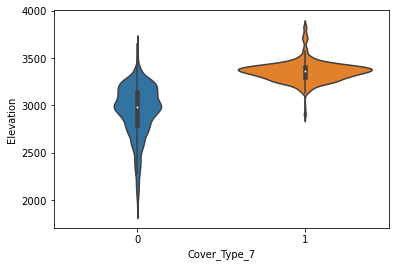

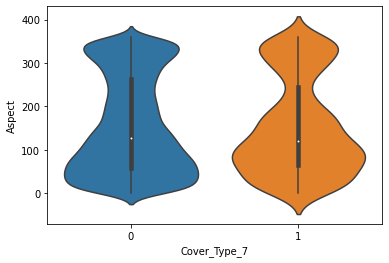

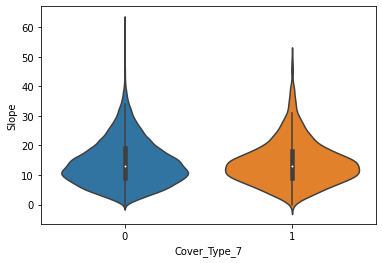

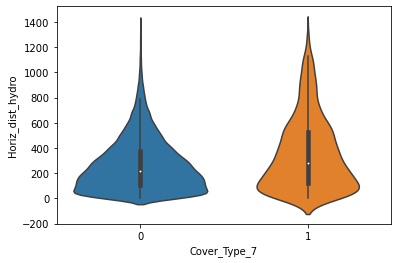

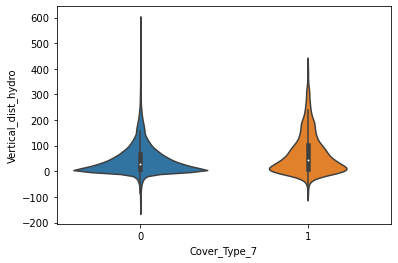

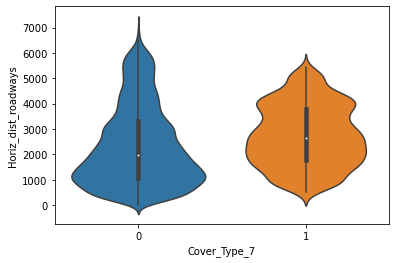

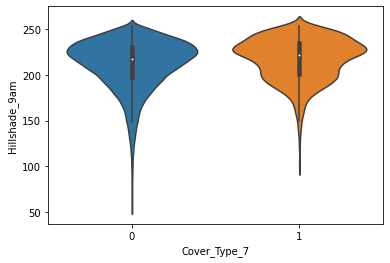

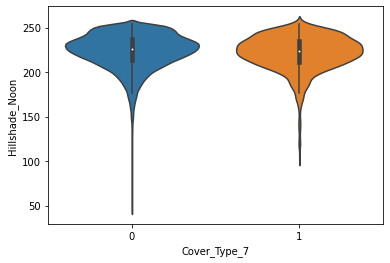

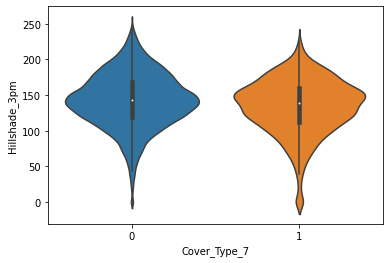

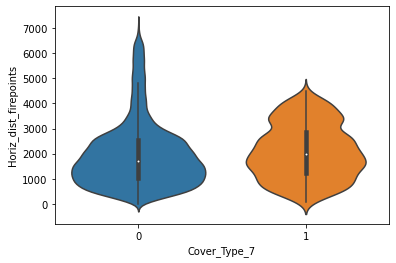

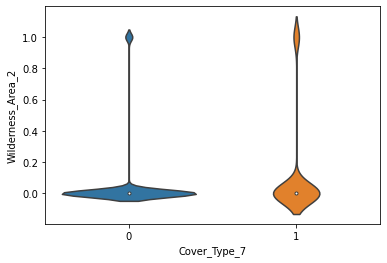

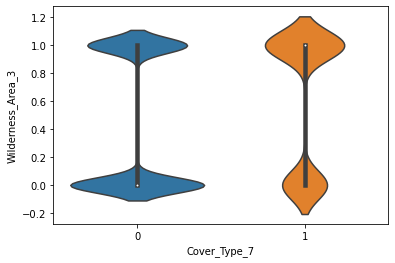

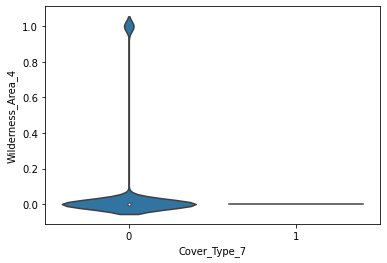

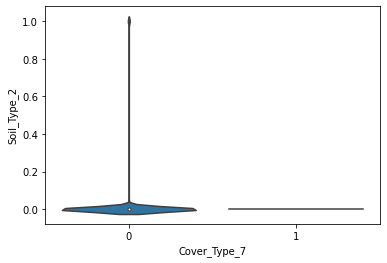

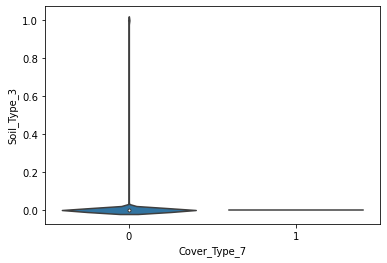

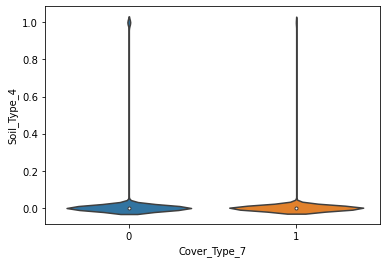

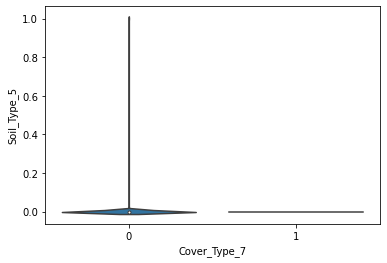

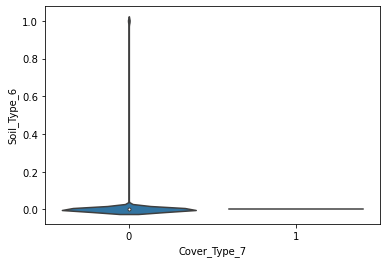

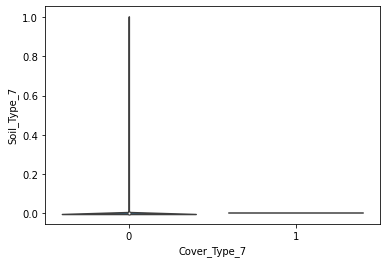

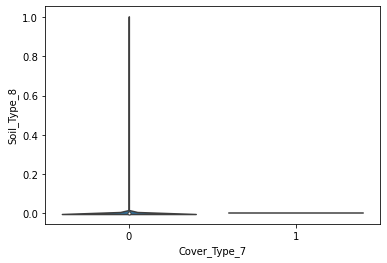

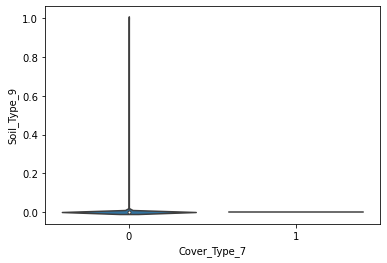

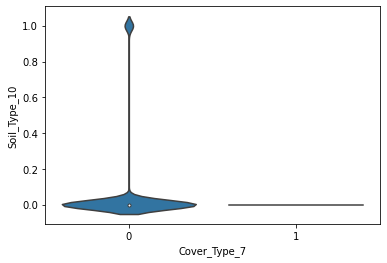

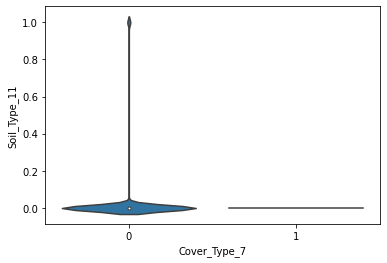

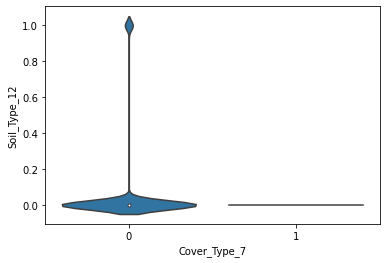

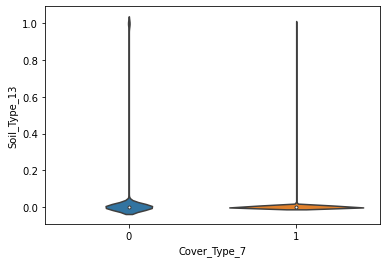

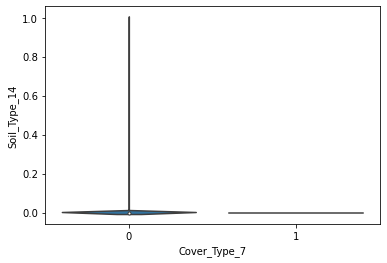

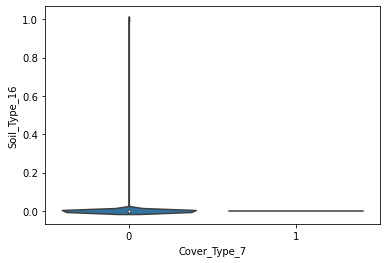

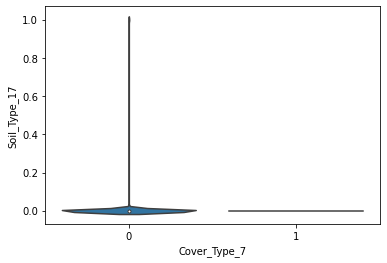

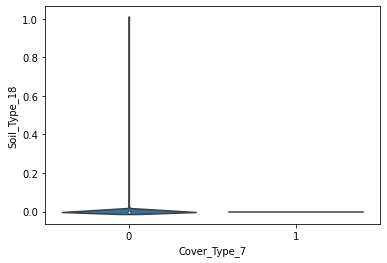

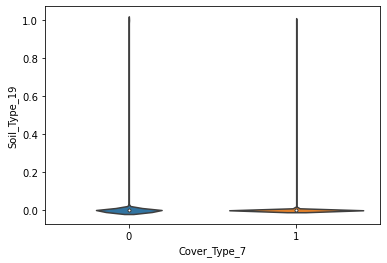

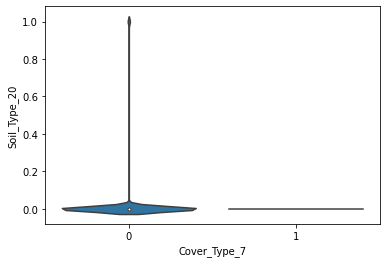

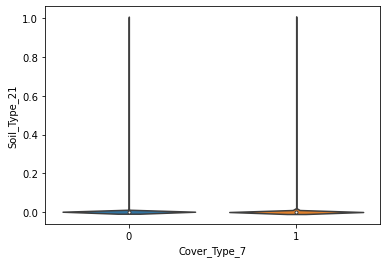

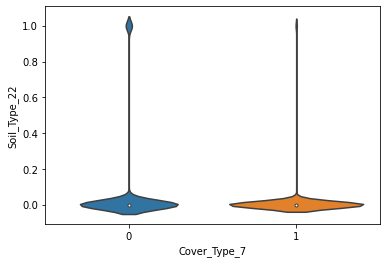

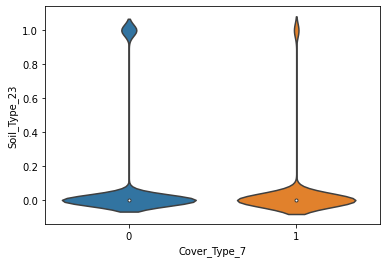

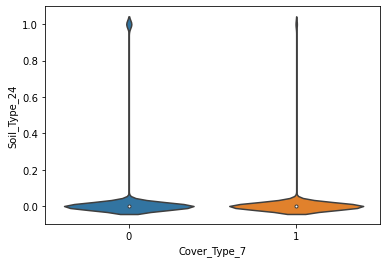

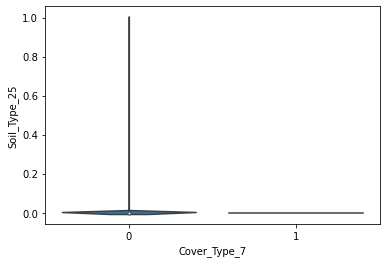

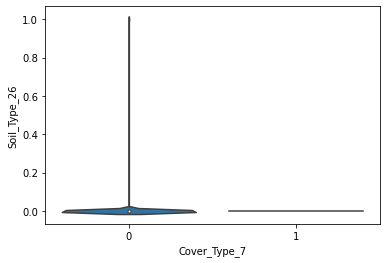

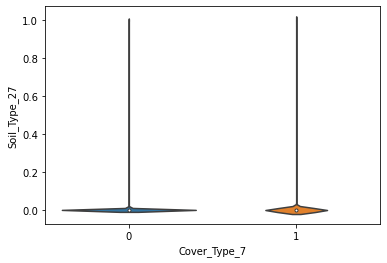

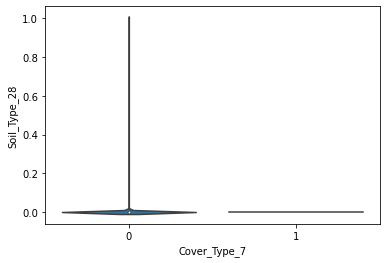

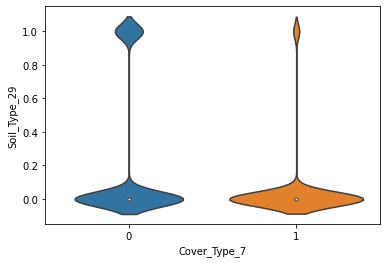

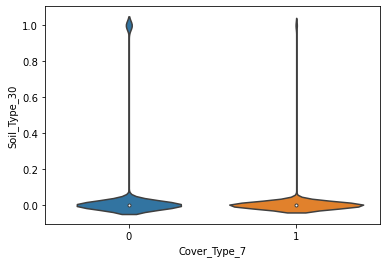

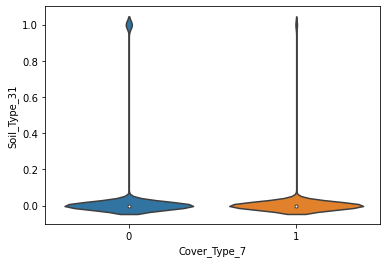

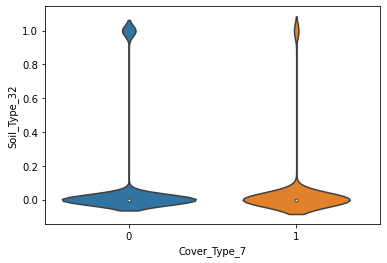

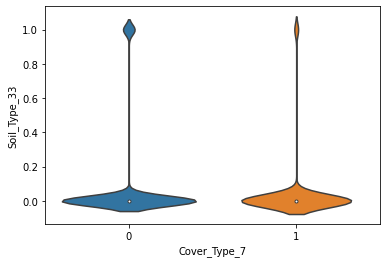

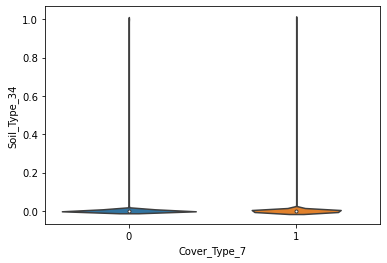

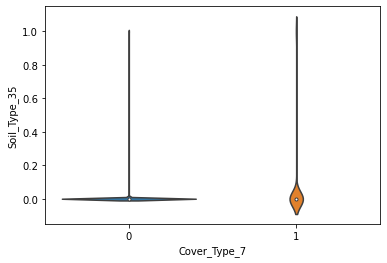

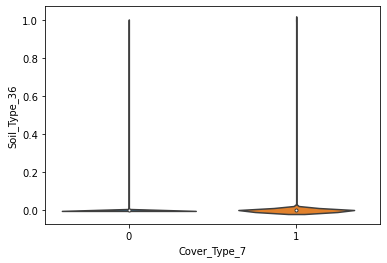

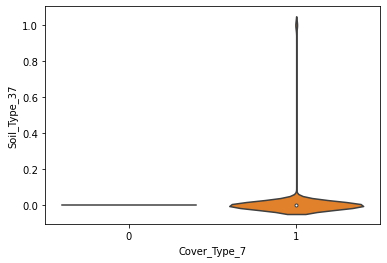

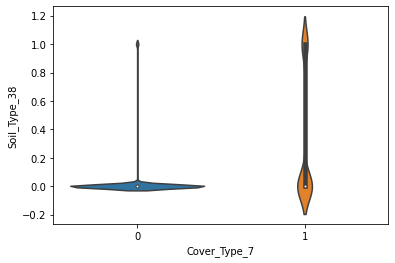

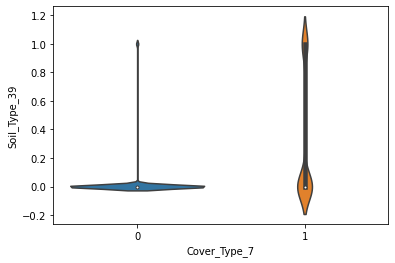

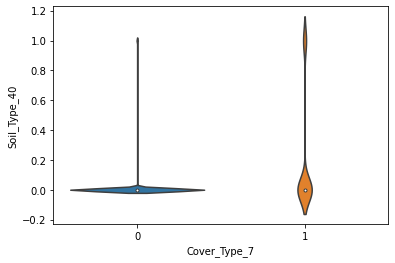

In [13]:
# I will visualize all the attributes using Violin Plot - a combination of box and density plots

import matplotlib.pyplot as plt

#names of all the attributes 
cols = list(train_data.columns)

#x-axis has target attribute to distinguish between classes
x = "Cover_Type_7"

#y-axis shows values of an attribute
y= [x for x in cols if not x.startswith("Cover_Type")]

#number of attributes (exclude target)
size=len(y)

#Plot violin for all attributes
for i in range(0,size):
    sns.violinplot(data=train_data,x=x,y=y[i])  
    plt.show()

**Comments on the violinplots:**

- Most of the Soil_Type dummies (if they are == 1) are not really present in the target variable.
- Other nmerical variables are there. 
- Hillshade_3pm shows a normal distribution. 
- Hillshade 9am and 12pm display are skewed.
- Slope is also skewed. 
- Wilderness_Area_4==1 is not present in Cover Type 7. 


### Numerical variables

Elevation               -0.823732
Aspect                   0.395705
Slope                    0.792498
Horiz_dist_hydro         1.135720
Vertical_dist_hydro      1.822710
Horiz_dist_roadways      0.717162
Hillshade_9am           -1.176385
Hillshade_Noon          -1.071671
Hillshade_3pm           -0.266931
Horiz_dist_firepoints    1.289249
dtype: float64


/var/folders/hc/qzy2rzvj5cg38v_607m73p640000gn/T/ipykernel_71339/576474774.py:10: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  numerical_columns.hist(ax = ax)


array([[<AxesSubplot:title={'center':'Elevation'}>,
        <AxesSubplot:title={'center':'Aspect'}>,
        <AxesSubplot:title={'center':'Slope'}>],
       [<AxesSubplot:title={'center':'Horiz_dist_hydro'}>,
        <AxesSubplot:title={'center':'Vertical_dist_hydro'}>,
        <AxesSubplot:title={'center':'Horiz_dist_roadways'}>],
       [<AxesSubplot:title={'center':'Hillshade_9am'}>,
        <AxesSubplot:title={'center':'Hillshade_Noon'}>,
        <AxesSubplot:title={'center':'Hillshade_3pm'}>],
       [<AxesSubplot:title={'center':'Horiz_dist_firepoints'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

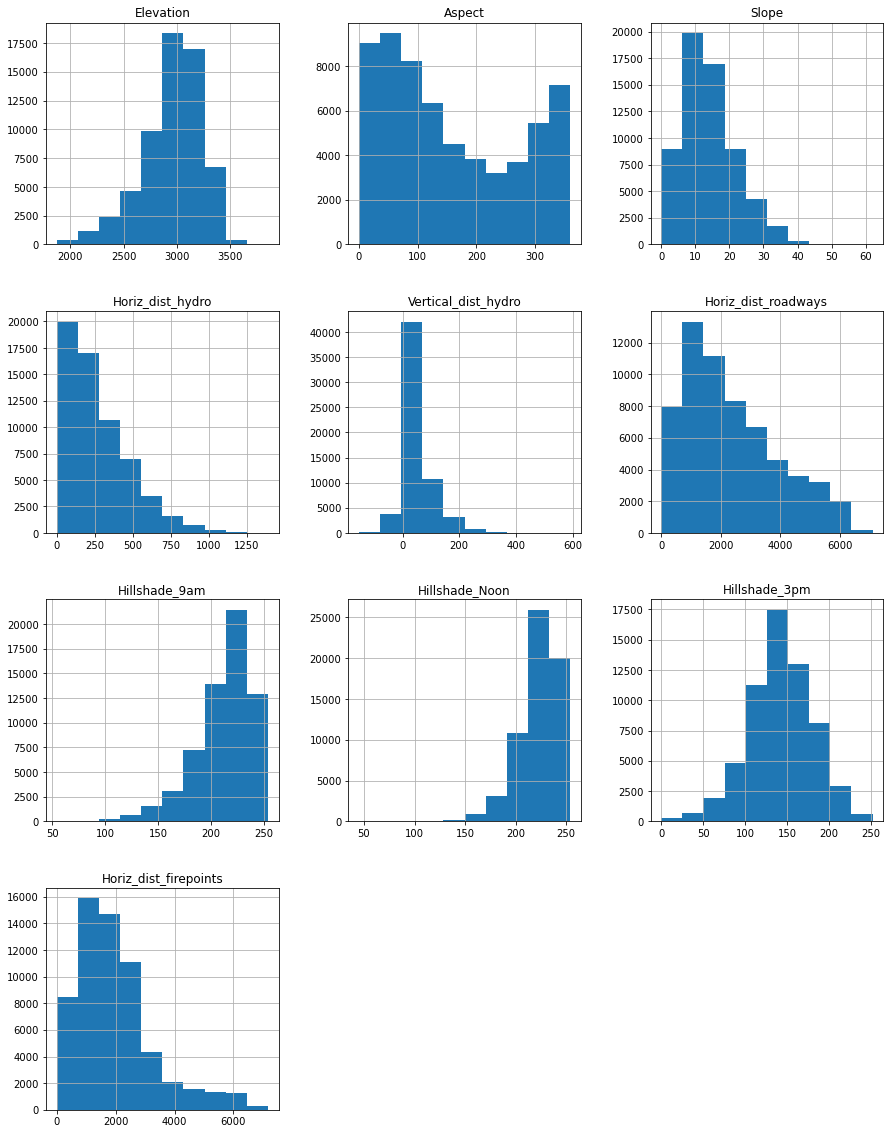

In [14]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns=train_data.select_dtypes(include=numerics)

# Skewness of their distribution
print(numerical_columns.skew())  # Values close to 0 show less skew

# plot histogram of each numerical columns to see their skewness visually
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
numerical_columns.hist(ax = ax)


- Skewed distribution:
    - Horiz_dist_hydro, Horiz_dist_roadways, Hillshade_9am, Hillshade_Noon and Horiz_dist_firepoints 
    
    
- Normal distribution:
    - Aspect, Hillshade_3pm 
    - (Vertical_dist_hydro: hard to decide)
    
    
- Elevation and Slope: hard to decide, close to normal, but rather skewed

In [15]:
#Removal list initialize
rem = []

#Add constant columns as they don't help in prediction process
for c in train_data.columns:
    if train_data[c].std() == 0: #standard deviation is zero
        rem.append(c)

#drop the columns        
train_data.drop(rem,axis=1,inplace=True)

print("Following columns are dropped:", rem)



Following columns are dropped: []


No columns are dropped after this process. 

# PART ONE: BINARY CLASSIFICATION

Build a binary model to predict COVER TYPE #7

In [16]:
# remove Index column before running a prediction
test=test_data.drop(columns="Index")
train=train_data.copy()

In [17]:
# Create X_train, y and X_test
X_original = train[train.columns.drop(list(train.filter(regex='Cover_')))] ## features everything except the covertype columns
y_original = train["Cover_Type_7"]
X_test_binary=test

# to print stats
feature_names = list(X_original.columns)
class_labels = ["cover type 7","not cover type 7"] # meant to represent 0 and 1


In [18]:
# check whether test and train set has the same columns
set(X_original.columns)-set(X_test_binary.columns),set(X_test_binary.columns)-set(X_original.columns)

(set(), set())

In [19]:
# Normalizing continous variables 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_original)
X_scaled = scaler.transform(X_original)

#scaler_test = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_test_binary)
X_test_binary_scaled = scaler.transform(X_test_binary)

## Define a base model

In [20]:
lregr = LogisticRegression(penalty='l2', C=100.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=500)


Confusion Matrix 

[[58827    16]
 [ 1846   317]]


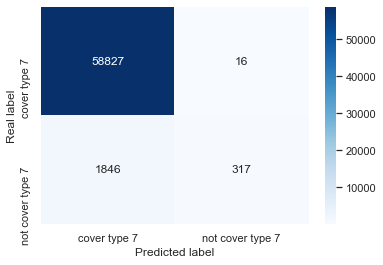

Confusion matrix of in-sample cross-validation:


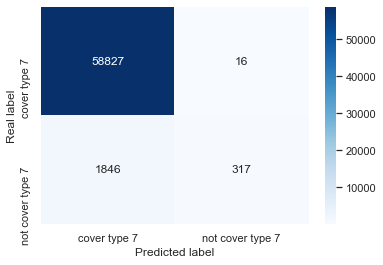

AUC:  0.9782932806245295


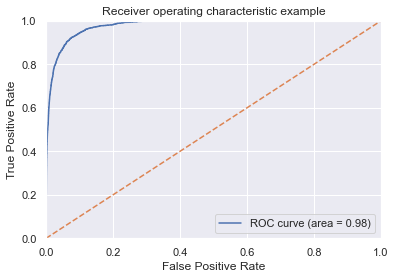

Classification report of the model: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     58843
           1       0.95      0.15      0.25      2163

    accuracy                           0.97     61006
   macro avg       0.96      0.57      0.62     61006
weighted avg       0.97      0.97      0.96     61006



In [29]:
# Evaluate model
predict_and_evaluate_binary(X_scaled, y_original,lregr, crossval="Yes" )

<Figure size 1440x1800 with 0 Axes>

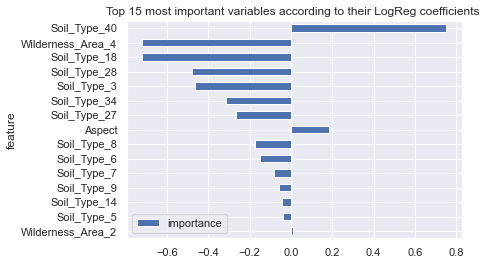

In [30]:
# Report variable impact
feature_importance_plot(lregr)

<AxesSubplot:title={'center':'pi_i'}, xlabel='Cover_Type_7'>

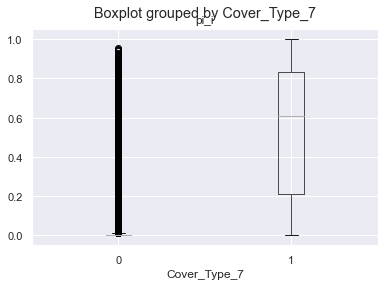

In [31]:
# let's see more globally the fitted probs
y_hat=lregr.predict_proba(X_scaled)
insample_pred_res = train.copy()

insample_pred_res["pi_i"] = y_hat[:,1]

insample_pred_res.boxplot(column="pi_i",by="Cover_Type_7") # colum is what to plot, by is how to straify

## Class imbalance
Try to improve prediction by using methods to tackle class imbalance.

Counter({0: 58843, 1: 2163})


<AxesSubplot:>

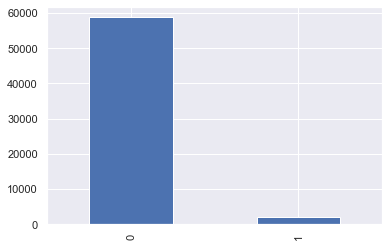

In [32]:
# Show visually class imbalance in the dataset for the target variable 
print(Counter(y_original))
train_data.Cover_Type_7.value_counts().plot(kind="bar")

### Over sampling with `LogisticRegression`:
(based on the classification_tutorcopy.ipynb)
using `LogisticRegression` `class_weight="balanced"` argument which analogous to `sklearn`'s `.over_sampling` method

In [33]:
# fit model
model_imb = LogisticRegression(C=100, class_weight='balanced', solver='liblinear')
model_imb.fit(X_scaled, y_original)


LogisticRegression(C=100, class_weight='balanced', solver='liblinear')

Confusion Matrix 

[[57543  1300]
 [  574  1589]]


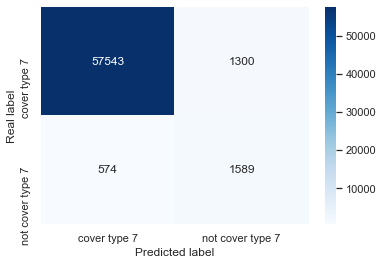

Confusion matrix of in-sample cross-validation:


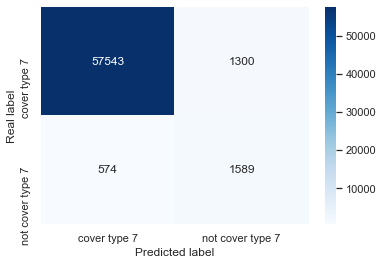

AUC:  0.9792089262282201


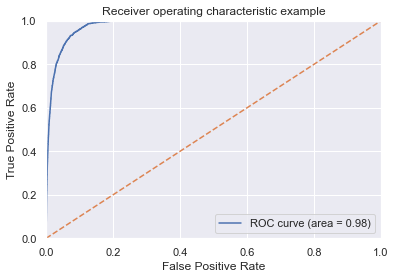

Classification report of the model: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     58843
           1       0.55      0.73      0.63      2163

    accuracy                           0.97     61006
   macro avg       0.77      0.86      0.81     61006
weighted avg       0.97      0.97      0.97     61006



In [34]:
# Evaluate model
predict_and_evaluate_binary(X_scaled, y_original, model_imb, crossval="Yes")

<Figure size 1440x1800 with 0 Axes>

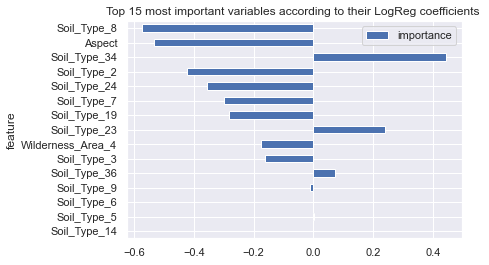

In [35]:
# Report variable impact
feature_importance_plot(model_imb)

**Conclusions:** 

AUC has slightly improved, but importance of different features has changed. 

Decision: continue hyperparameter finetuning with `model_imb`

### Finetune hyperparameters of `Logistic Regression` if `class_weight="balanced"`

In [36]:
# define model and parameters
model = LogisticRegression()
class_weight='balanced',
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
#c_values=np.logspace(-4, 4, 20)
c_values = [10000, 10000, 200,100, 10, 1.0, 0.1, 0.01, 0.0001, 0.001]

finetune_model(X_scaled,y_original, model, class_weight, solvers, penalty, c_values)

Best: 0.977698 using {'C': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.977313 (0.002601) with: {'C': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.977698 (0.002456) with: {'C': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.977486 (0.002551) with: {'C': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
0.977313 (0.002601) with: {'C': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.977698 (0.002456) with: {'C': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.977486 (0.002551) with: {'C': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
0.977533 (0.002512) with: {'C': 200, 'penalty': 'l2', 'solver': 'newton-cg'}
0.977697 (0.002435) with: {'C': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
0.977542 (0.002501) with: {'C': 200, 'penalty': 'l2', 'solver': 'liblinear'}
0.977566 (0.002492) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.977689 (0.002435) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.977573 (0.002482) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.977477 (

/Users/pazma/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9776975427389119, {'C': 10000, 'penalty': 'l2', 'solver': 'lbfgs'})

From this output we can see that the higher the C value is the better the accuracy of our model is. Additionally, setting `solver='lbfgs'` gives better results too. But the improvement is not that large, that it would have a significant effect on the test set. So all in all, we can choose one these models at the end, but it does not gurantee, that our Accuracy or AUC score will improve significantly for the test set. 



Confusion Matrix 

[[57545  1298]
 [  573  1590]]


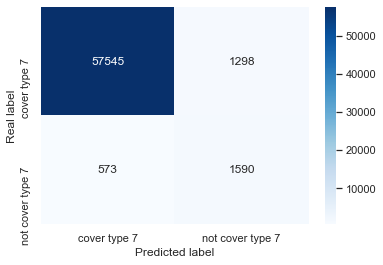

Confusion matrix of in-sample cross-validation:


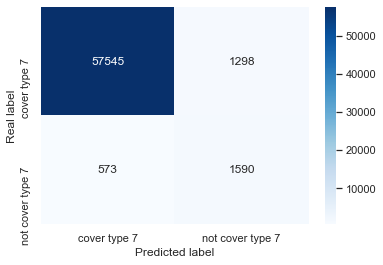

AUC:  0.9792079598351974


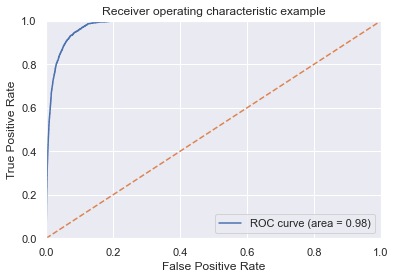

Classification report of the model: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     58843
           1       0.55      0.74      0.63      2163

    accuracy                           0.97     61006
   macro avg       0.77      0.86      0.81     61006
weighted avg       0.97      0.97      0.97     61006



In [37]:
# Evaluate best model with reweighting y values after prediction
model_imb_finetuned = LogisticRegression(
                            penalty='l2',
                            C=10000, 
                            solver='liblinear', 
                            class_weight="balanced")

predict_and_evaluate_binary(X_scaled, y_original, model_imb_finetuned, crossval="Yes" )

If we look at the results of the model evaluation, we can see that our AUC has only improved by a 0.00001. This is insignificant. 

Furthermore, the confusion matrix of the finetuned model shows that it has not achieved significantly better scores neither on Type I, nor on Type II error. Number of false positives (Type I) decreased by one (from 574 to 573), while number of false negatives (Type II) decreased by 3 (from 1300 to 1298). 


<Figure size 1440x1800 with 0 Axes>

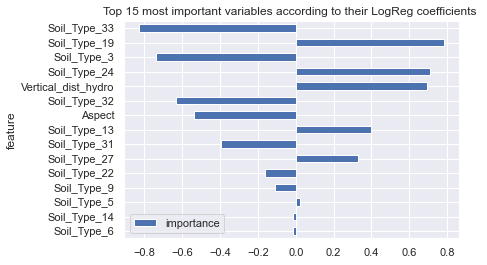

In [38]:
feature_importance_plot(model_imb_finetuned)

However feature importance has changed. In the previous model, for example Aspect was the second most important variable, but in this case it fell back to 7th place. Other than that, we can still see the same trend as before, that the Soil Type variables play an important role in predicting Cover Type #7. 

**Conclusions of comparing the results and evaluations of the finetuned and 'basic' model:** 

AUC has not improved, neither Accuracy 

So finetuneing does not help to improve my model significantly. 

At this stage it is advised to use PolynomialFeatures. I am using degree=2, because my computer's memory cannot handle degree=3. 

### Try with `PolynomialFeatures(degree=2)` and `class_weight='balanced'`

In [105]:
class_labels=["cover type 7", "not cover type 7"]

In [39]:
poly=PolynomialFeatures(degree=2)
X_poly=poly.fit_transform(X_original)
X_test_poly=poly.fit_transform(X_test_binary)

In [40]:
X_poly.shape, X_test_poly.shape

((61006, 1378), (13073, 1378))

In [41]:
# Normalizing continous variables 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_poly)
X_scaled_poly = scaler.transform(X_poly)

X_test_scaled_poly = scaler.transform(X_test_poly)

Confusion Matrix 

[[58020   823]
 [  267  1896]]


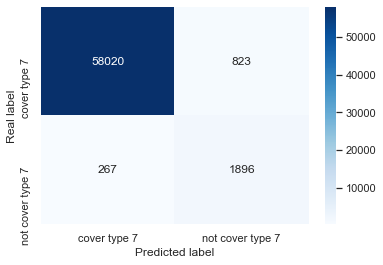

AUC:  0.9940010171011573


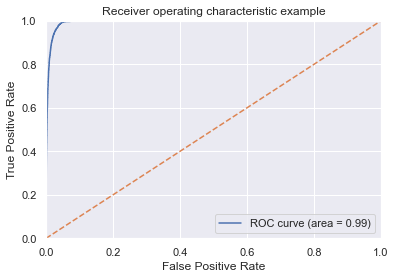

Classification report of the model: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     58843
           1       0.70      0.88      0.78      2163

    accuracy                           0.98     61006
   macro avg       0.85      0.93      0.88     61006
weighted avg       0.98      0.98      0.98     61006

No cross-validation


In [106]:
# Predict and evalute the LogisticRegression (class_weight='balanced') model with the polynomials
predict_and_evaluate_binary(X_scaled_poly, y_original,model_imb_finetuned, crossval="No" )

In [44]:
# Kaggle submission
# create predictions for the test set
model_imb_finetuned.fit(X_scaled_poly, y_original)
y_hat_pred=model_imb_finetuned.predict_proba(X_test_scaled_poly)

# reweighting 
q1 = y_original.sum()/len(y_original)
r1 = 0.5
y_hat_corr=reweight(y_hat_pred[:,1], q1,r1)



test_predictions_submit = pd.DataFrame({"Index": raw_test["Index"], "Cover_Type": y_hat_corr})
test_predictions_submit.to_csv("test_LogReg_predictions_submit_binary.csv", index = False)

##############################################################################################################

## Additional things to handle class imbalance
### $\;\;\;\;\;\;$ Random OverSampling and UnderSampling with sklearn

Interesting results may be achieved by combining both random oversampling and undersampling.

For example, a modest amount of oversampling can be applied to the minority class to improve the bias towards these examples, whilst also applying a modest amount of undersampling to the majority class to reduce the bias on that class.

This can result in improved overall performance compared to performing one or the other techniques in isolation.

Bias: 
- the random *oversampling* may increase the likelihood of occurring *overfitting*, since it makes exact copies of the minority class examples. In this way, a symbolic classifier, for instance, might construct rules that are apparently accurate, but actually cover one replicated example.
- in random *under-sampling* (potentially), vast quantities of data are discarded. […] This can be highly problematic, as the *loss of such data* can make the decision boundary between minority and majority instances harder to learn, resulting in a *loss in classification performance*.





In this part, I tried out different versions and combination of resampling the dataset, to see how they change prediction results. 

I used  `sklearn`'s `imblearn` library for this part. 

I experienced with different resampling strategies, such as SMOTE, Tomek or combined different Over-and UnderSampling ratios to see whether thanks to them my prediction will perform better. 

In [45]:
# Class imbalance in our dataset
print(Counter(y_original))

Counter({0: 58843, 1: 2163})


### Evaluate Random Under-and OverSampling with different resampling strategies

In [46]:
## Look at and evaluate the performance of different over-and undersampling methods
ratios=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sampling_methods1=["under", "over"]
results_all=dict()
for s in sampling_methods1:
    for r in ratios:
        dic_key=str(s+"_"+str(r))
        results_all[dic_key]=(sampling_and_evaluate(X_scaled, y_original, s, r))

sampling_methods2=["under", "over", "tomek", "smote", "smotetomek"]
for s in sampling_methods2:
    if (s=="under")|(s=="tomek"):
        dic_key=str(s+"_"+ "majority")
        results_all[dic_key]=(sampling_and_evaluate(X_scaled, y_original, s, "majority"))
    else:
        dic_key=str(s+"_"+ "minority")
        results_all[dic_key]=(sampling_and_evaluate(X_scaled, y_original, s, "minority"))
        
        


In [47]:
# Show top 5 best results
dict(sorted(results_all.items(), key=lambda item: item[1], reverse=True)[:5])

{'smotetomek_minority': 0.9803260496591706,
 'smote_minority': 0.980312781054893,
 'under_0.3': 0.9800875652362934,
 'under_0.4': 0.9800766818171442,
 'over_0.3': 0.979949492201879}

#### Finetune and evaluate model for smote_tomek sampling method

In [48]:
# Re-sample dataset     
smotetomek = SMOTETomek(sampling_strategy="minority", random_state=42)
X_smtl, y_smtl = smotetomek.fit_resample(X_scaled, y_original)

In [49]:
# define model and parameters
model = LogisticRegression()
class_weight=None
solvers = ['liblinear']
penalty = ['l2']
c_values = [10000, 1000, 100, 10, 1.0, 0.1, 0.01, 0.0001, 0.001]
#c_values=np.logspace(-4, 4, 20)

finetune_model(X_smtl, y_smtl, model, class_weight, solvers, penalty, c_values)

Best: 0.980495 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.980265 (0.001121) with: {'C': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
0.980265 (0.001121) with: {'C': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
0.980268 (0.001121) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.980309 (0.001113) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.980495 (0.001079) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.978882 (0.001053) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.968460 (0.001192) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.921188 (0.002846) with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
0.940756 (0.002274) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


(0.9804946334497278, {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'})

Confusion Matrix 

[[58841     2]
 [ 2033   130]]


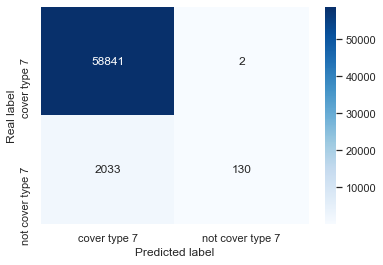

Confusion matrix of in-sample cross-validation:


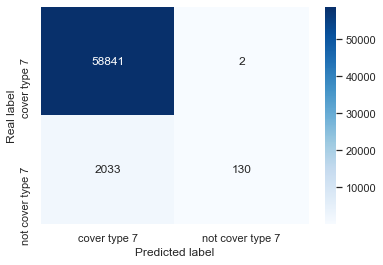

AUC:  0.9743157483666249


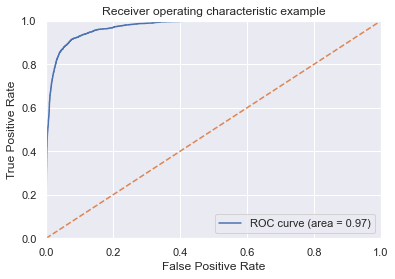

Classification report of the model: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     58843
           1       0.98      0.06      0.11      2163

    accuracy                           0.97     61006
   macro avg       0.98      0.53      0.55     61006
weighted avg       0.97      0.97      0.95     61006



In [51]:
# Evaluate model
smotetomek_model=LogisticRegression(
                            penalty='l2',
                            C=1, 
                            solver='liblinear' 
                        )
predict_and_evaluate_binary(X_scaled, y_original, smotetomek_model )

### Combining Random Oversampling and Undersampling with different ratios 

*Find the best combination of over-and uncersampling ratios on the dataset*

In [54]:
from pandas.core.common import flatten
import re

ratios=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ratios_reversed= sorted(ratios,reverse=True)

results_combined=dict()

r1,r2=test_evaluate_sampling_ratios(ratios,ratios_reversed, results_combined)

# Show top 5 best results:
# results are evaluted based on their AUC score
(dict(sorted(results_combined.items(), key=lambda item: item[1], reverse=True)[:5]))


{'OverSampler ratio: 0.1, UnderSampler ratio: 0.9': 0.9783766297310702}

In this case I think it is not worth it to find the best model (finetune hyperparameters), becasue based on previous results the AUC score has not improved significantly with different kinds of sampling strategy. As a consequence, I think it is best to rely on previous results and use a rather high C-value (`c=1000`), with `'l2'` penalty and a `'liblinear'` solver given the fact the `'lbfgs'` gives a lot of warning and applying that solver does not show significant improvement in prediction results. 

AUC:  0.9790054822587567


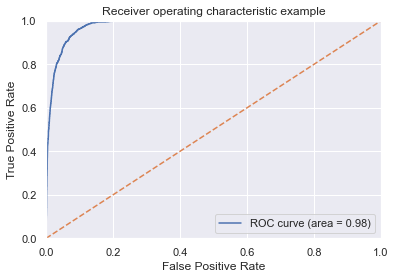

Classification report of the model: 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      6537
           1       0.92      0.93      0.93      5884

    accuracy                           0.93     12421
   macro avg       0.93      0.93      0.93     12421
weighted avg       0.93      0.93      0.93     12421



In [61]:
# Show the classification report of the best version of sampling strategy
model=LogisticRegression(penalty='l2', C=1000.0,  
                           solver='liblinear', max_iter=500)
evaluate_best_sampling(r1, r2, model)

#####################################################################################################################

### Conclusions of Binary Classification results
#### *Based on the evaluation results of the different sampling methods:* 



**Best model**: predictions with `PolynomialFeatures(degree=2)` and with the reweighted and finetuned LogisticRegression model: AUC score=0.99, Accuracy=0.98.

- Looking at the train test AUC score and Accuracy, so far this is the best model, but after submitting my predictions on the test set, my Kaggle score hasn't improved.

- Additionally, the number of Type I and Type II errors also decreased, which is also an evidence that the model has improved and was able to better classify the observations.  

- Precision for class 1 has also significantly improved. 

- With trying out different resampling strategies, I did not achieve an improvement in the performance of my model, the AUC scores remained between 0.97 and 0.98. On the other hand, in Accuracy scores we can see some significant changes, for example when combining different Under-and OverSample strategies, accuracy went down to 0.93. 




<hr style="border:10px black"> </hr>

# PART TWO: MULTI-CLASS CLASSIFICATION

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64


<BarContainer object of 7 artists>

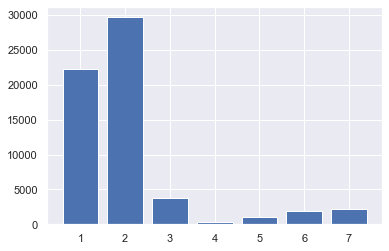

In [62]:
# How many observations by group Cover Type?
print(raw_train["Cover_Type"].value_counts())
barplot=pd.DataFrame(raw_train["Cover_Type"].value_counts())
plt.bar(barplot.index, barplot.Cover_Type)

Cover Types 1 and 2 has more observations than Cover Type 3-7. 

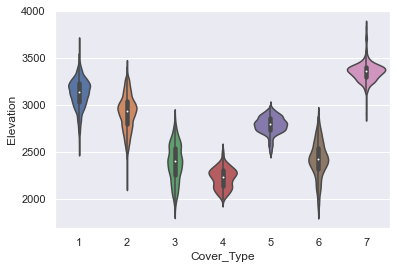

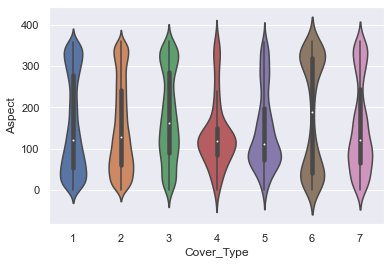

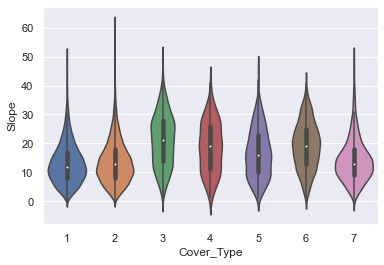

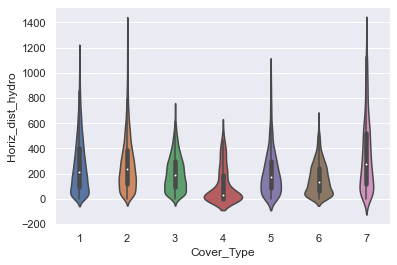

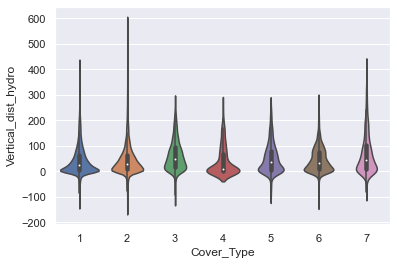

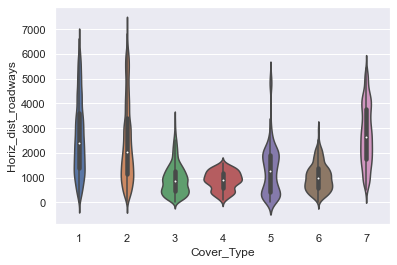

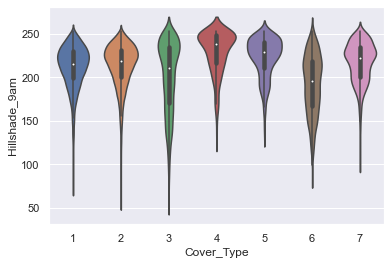

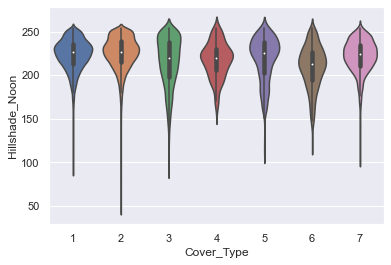

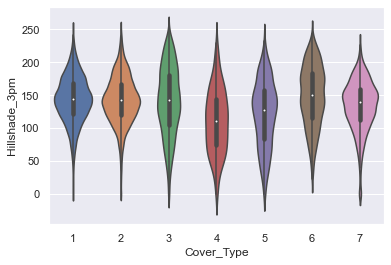

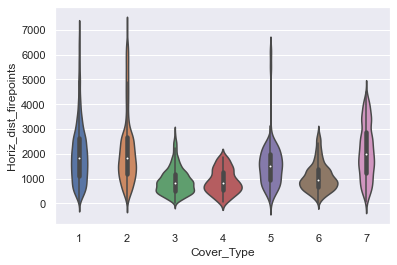

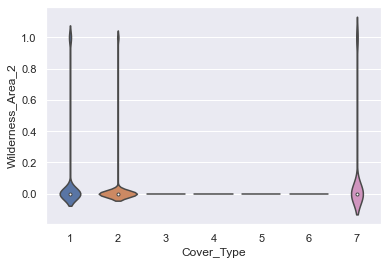

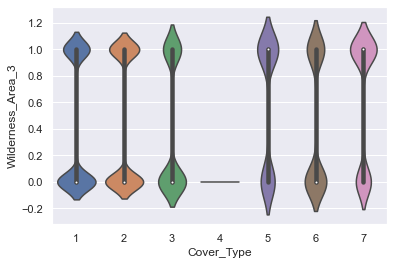

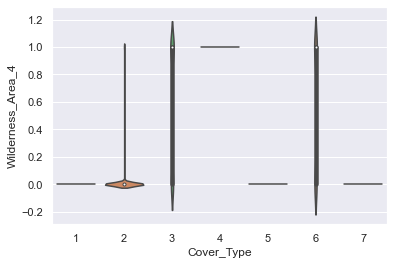

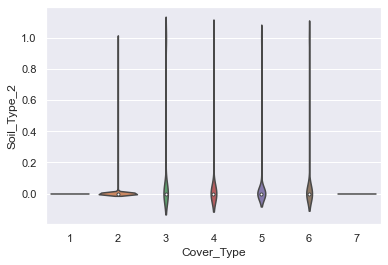

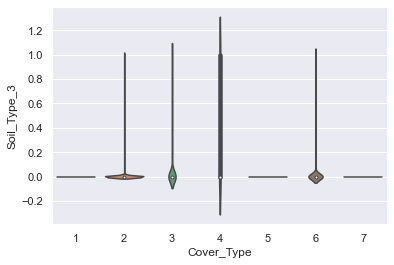

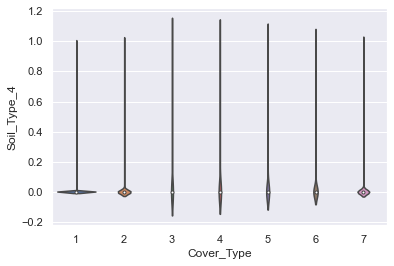

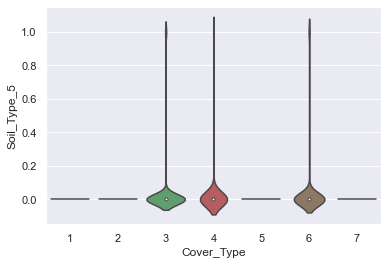

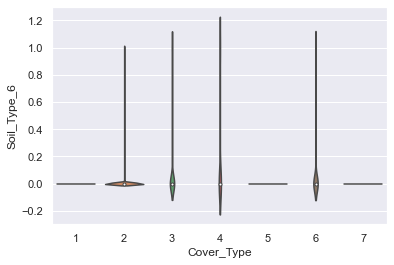

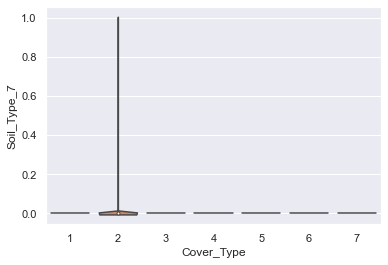

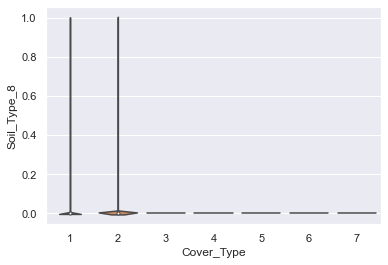

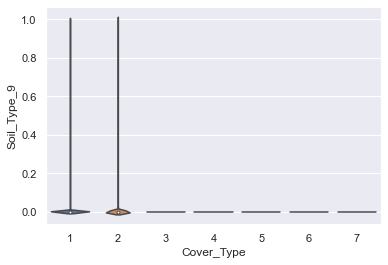

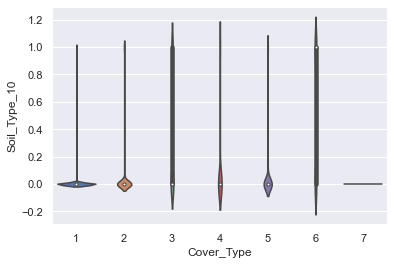

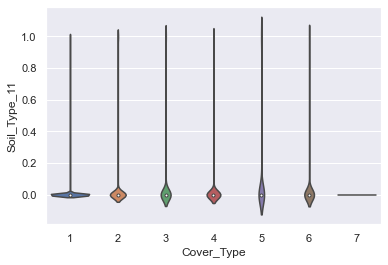

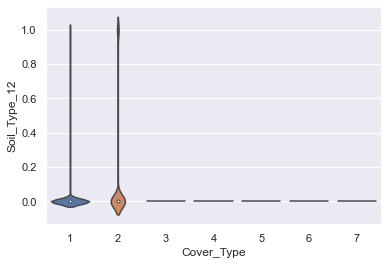

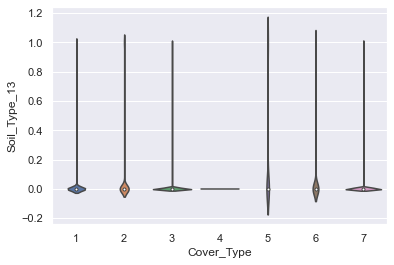

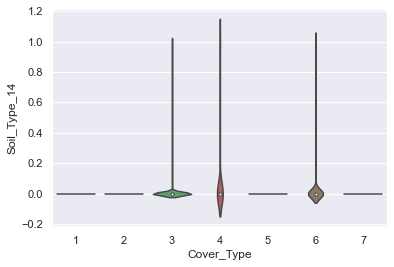

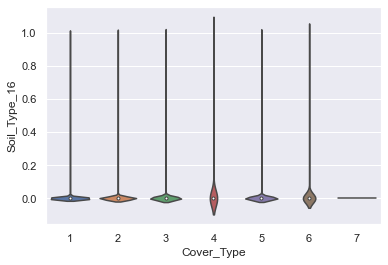

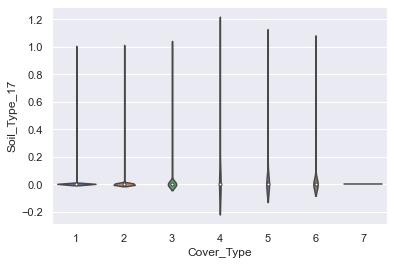

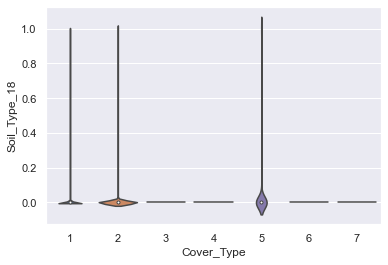

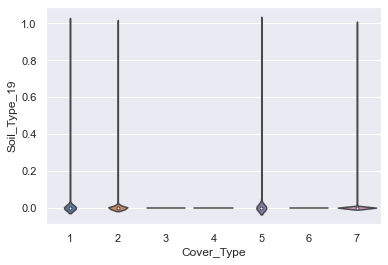

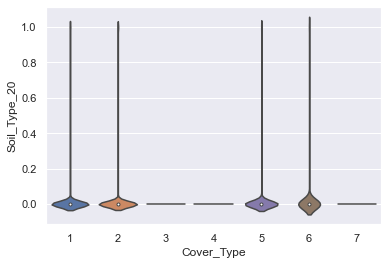

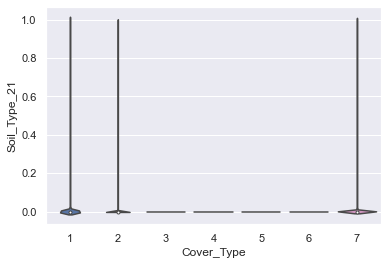

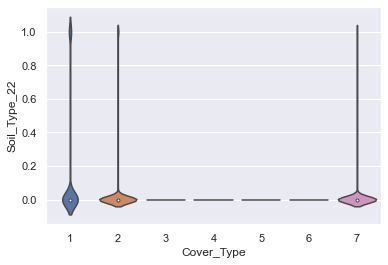

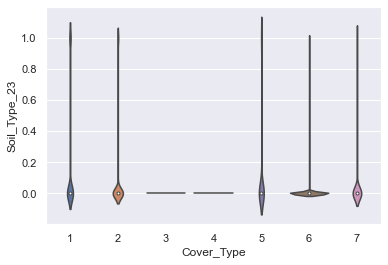

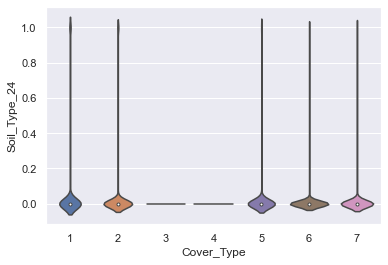

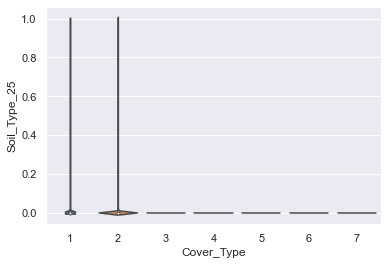

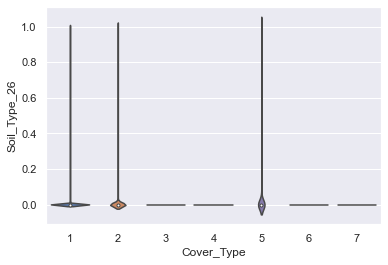

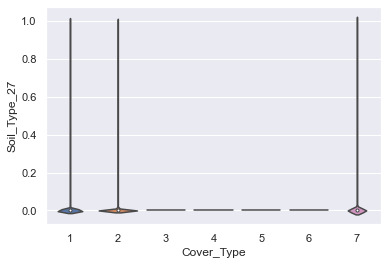

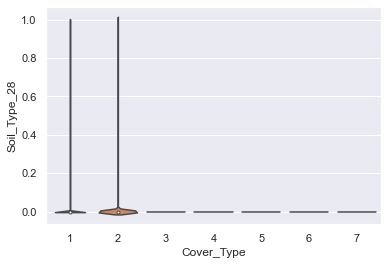

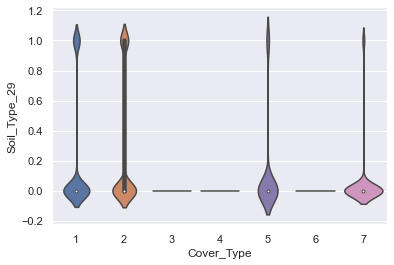

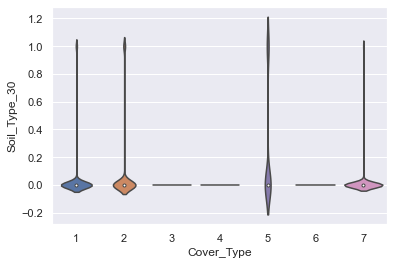

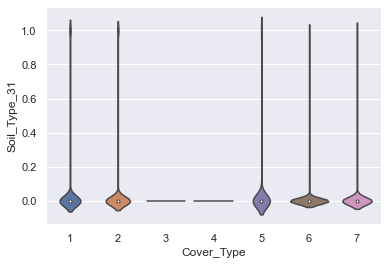

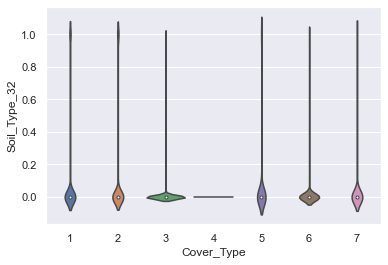

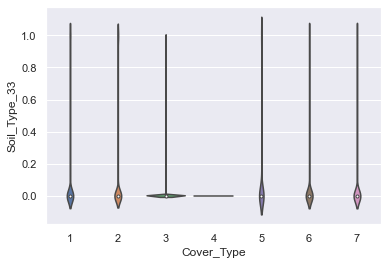

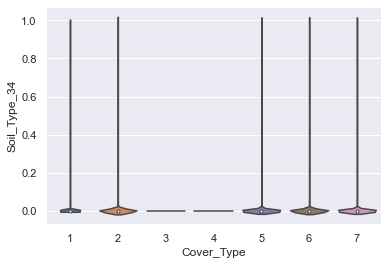

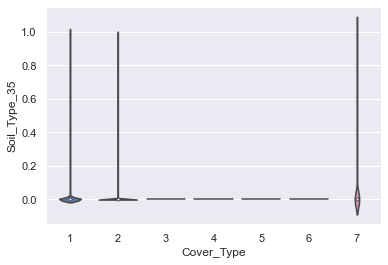

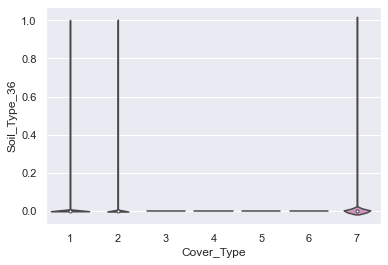

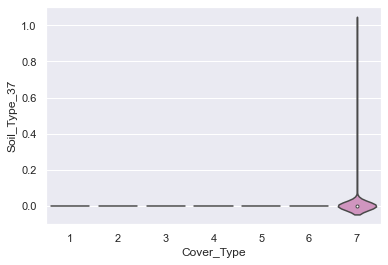

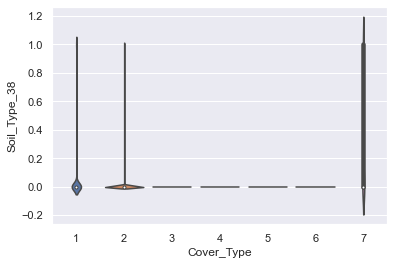

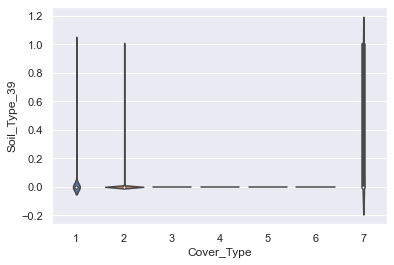

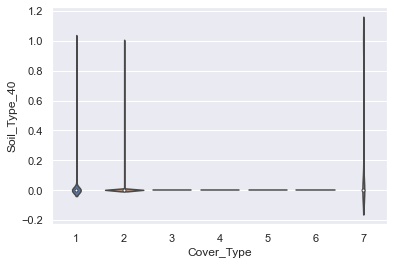

In [63]:
# I will visualize all the attributes using Violin Plot so that we will see the distribution of each class within different features

# Recreate dummies for train data, wihtout Cover Type because in train_data and test_data datasets Cover_Type_1 is missing
train_data=get_dummies(raw_train, ["Wilderness_Area", "Soil_Type"]) # this function does not keep the first type

#names of all the attributes 
cols = list(train_data.columns)

#x-axis has target attribute to distinguish between classes
x = "Cover_Type"

#y-axis shows values of an attribute
y= [x for x in cols if not x.startswith("Cover_Type")]

#number of attributes (exclude target)
size=len(y)

#Plot violin for all attributes
for i in range(0,size):
    sns.violinplot(data=train_data,x=x,y=y[i])  
    plt.show()

Based on the violinplots: 
- Elevation has a seperate distribution for most classes
- Aspect contains a couple of normal distributions for a couple of classes
- Slope, Hillshade 3pm is normally distributed
- Hillshade 9am, 12pm is skewed
- Wilderness Area 2 is not present in Cover Type 3,4,5,6
- Wilderness Area 3 is not present in Cover Type 4
- Wilderness Area 4, Soil Type 2,3,4,6,7,8,9 is not present in either or very few of the classes
- Soil Type 5 is present only in Cover Type 3,4,6 
- Soil Tpye 12 is present in Cover Type 1,2
    

In [64]:
# Recreate dummies for train and test data without Cover Type dummies 
train_data=get_dummies(raw_train, ["Wilderness_Area", "Soil_Type"]) 
test_data=get_dummies(raw_test, ["Wilderness_Area", "Soil_Type"])



In [65]:
# Use the square of Elevation variable
# Add interaction terms of Elevation (Elevation and Elevation squared) with Soil Type
train_v2=train_data.copy()
train_v2["Elevation_sq"]=train_v2["Elevation"]**2

soil_type_columns=[x for x in list(train_data.columns) if x.startswith("Soil_Type")]

# Interact them
for c in soil_type_columns:
    train_v2["Elevation_"+c]=train_v2["Elevation"]*train_v2[c]
    train_v2["Elevation_sq_"+c]=train_v2["Elevation_sq"]*train_v2[c]

# do the same for the test data
test_data_2=test_data.drop(columns="Index")
test_data_2["Elevation_sq"]=test_data_2["Elevation"]**2

for c in soil_type_columns:
    test_data_2["Elevation_"+c]=test_data_2["Elevation"]*test_data_2[c]
    test_data_2["Elevation_sq_"+c]=test_data_2["Elevation_sq"]*test_data_2[c]




In [67]:
# create X_train, y, X_test
X_multi=train_v2.drop(columns="Cover_Type")
y_multi=train_v2.Cover_Type
X_test_multi=test_data_2

In [68]:
X_multi.shape, X_test_multi.shape

((61006, 128), (13073, 128))

In [69]:
# rescale 
scaler_multi = MinMaxScaler(feature_range = (0,1))

scaler_multi.fit(X_multi)
X_multi_scaled = scaler_multi.transform(X_multi)

X_test_multi_scaled = scaler_multi.transform(X_test_multi)

In [70]:
X_test_multi_scaled.shape, X_multi_scaled.shape

((13073, 128), (61006, 128))

### Define a basic model without reweighting and handling imbalance

In [73]:
class_labels=[1,2,3,4,5,6,7]

In [ ]:
model_multi=LogisticRegression(C=100, penalty="l2", solver="lbfgs", 
                    multi_class='multinomial', max_iter=10000)
model_multi.fit(X_multi_scaled, y_multi)
y_pred=model_multi.predict(X_multi_scaled)
        
accuracy_score(y_multi,y_pred)
class_labels=[1,2,3,4,5,6,7]
confusion_matrix_(X_multi_scaled, y_multi,y_pred, model_multi, class_labels)


In [77]:
# Classification report
print("Classification report of the model: \n", 
    metrics.classification_report(y_multi, y_pred))

Classification report of the model: 
               precision    recall  f1-score   support

           1       0.71      0.71      0.71     22199
           2       0.75      0.80      0.77     29690
           3       0.66      0.82      0.73      3802
           4       0.51      0.34      0.41       295
           5       0.26      0.02      0.03       992
           6       0.49      0.25      0.33      1865
           7       0.74      0.56      0.64      2163

    accuracy                           0.73     61006
   macro avg       0.59      0.50      0.52     61006
weighted avg       0.72      0.73      0.72     61006



### Handle class imbalance: Define a model with `class_weight='balanced'` and reweighted values

In [78]:
# model
model_imb_multi=LogisticRegression(C=100, penalty="l2", solver="lbfgs", 
                    multi_class='multinomial', class_weight="balanced",max_iter=10000 )

In [79]:
# fit model
model_imb_multi.fit(X_multi_scaled, y_multi)

LogisticRegression(C=100, class_weight='balanced', max_iter=10000,
                   multi_class='multinomial')

In [80]:
# correcting for biased sample
## the correction factor:
freq = pd.Series(y_multi.value_counts())
q = []
for i in range(1, len(freq)+1):
    a = freq[i]/len(y)
    q.append(a)    
r = 1/7

y_prob_imb_corr = reweight_multi(pd.DataFrame(model_imb_multi.predict_proba(X_multi_scaled)),q,r)

In [ ]:
# get the maximum value of each row in the y_pred array and find their position to know to which class they were predicted
class_labels_multi=[]
for i in range(y_prob_imb_corr.shape[0]):
        class_labels_multi.append(np.where(y_prob_imb_corr[i,:] == np.amax(y_prob_imb_corr[i,:]))[0][0]+1) 
        


unfortunately the confusion matrix with the cross validation runs for a very long time, thus I created a confusion matrix function without the cross-validation procedure. But if you would like to run it, you have to comment out the confusion_matrix_ row

In [82]:
%run linclass_my_functions.ipynb

0.7285840736976691


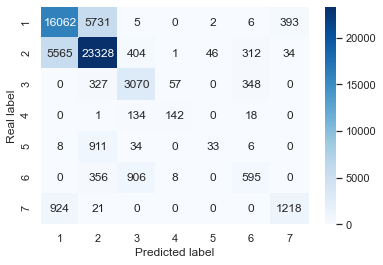

Classification report of the model: 
               precision    recall  f1-score   support

           1       0.71      0.72      0.72     22199
           2       0.76      0.79      0.77     29690
           3       0.67      0.81      0.73      3802
           4       0.68      0.48      0.56       295
           5       0.41      0.03      0.06       992
           6       0.46      0.32      0.38      1865
           7       0.74      0.56      0.64      2163

    accuracy                           0.73     61006
   macro avg       0.63      0.53      0.55     61006
weighted avg       0.72      0.73      0.72     61006



In [83]:
# evaluate 
print(accuracy_score(y_multi,class_labels_multi))
class_labels=[1,2,3,4,5,6,7]


#confusion_matrix_(X_multi_scaled, y_multi,class_labels_multi, model_imb_multi, class_labels)
confusion_matrix_wo_crossval(X_multi_scaled, y_multi,class_labels_multi, model_imb_multi, class_labels)

# Classification report
print("Classification report of the model: \n", 
    metrics.classification_report(y_multi, class_labels_multi))

### Try with `PolynomialFeatures(degree=2)` 

In [94]:
X_multi_poly=train_data.drop(columns="Cover_Type")
X_test_multi_poly=test_data.drop(columns="Index")

In [95]:
X_multi_poly.shape, X_test_multi_poly.shape

((61006, 51), (13073, 51))

In [96]:
poly=PolynomialFeatures(degree=2)
poly.fit(X_multi_poly)
X_train_multi_poly=poly.transform(X_multi_poly)
X_test_multi_poly=poly.transform(X_test_multi_poly)

In [97]:
X_train_multi_poly.shape, X_test_multi_poly.shape

((61006, 1378), (13073, 1378))

In [98]:
# Normalizing continous variables 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train_multi_poly)
X_multi_scaled_poly = scaler.transform(X_train_multi_poly)

X_multi_test_scaled_poly = scaler.transform(X_test_multi_poly)

In [99]:
# fit model
model_imb_multi.fit(X_train_multi_poly, y_multi)

# correcting for biased sample
## the correction factor:
freq = pd.Series(y_multi.value_counts())
q = []
for i in range(1, len(freq)+1):
    a = freq[i]/len(y)
    q.append(a)    
r = 1/7

y_poly_prob_imb_corr = reweight_multi(pd.DataFrame(model_imb_multi.predict_proba(X_train_multi_poly)),q,r)

# get the maximum value of each row in the y_pred array and find their position to know to which class they were predicted
class_labels_multi_poly=[]
for i in range(y_poly_prob_imb_corr.shape[0]):
        class_labels_multi_poly.append(np.where(y_poly_prob_imb_corr[i,:] == np.amax(y_poly_prob_imb_corr[i,:]))[0][0]+1)
        

/Users/pazma/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [100]:
print(accuracy_score(y_multi,class_labels_multi_poly))

# Classification report
print("Classification report of the model: \n", 
    metrics.classification_report(y_multi, class_labels_multi_poly))

0.7074058289348588
Classification report of the model: 
               precision    recall  f1-score   support

           1       0.69      0.70      0.70     22199
           2       0.74      0.77      0.76     29690
           3       0.62      0.78      0.69      3802
           4       0.78      0.51      0.61       295
           5       0.58      0.06      0.11       992
           6       0.47      0.32      0.38      1865
           7       0.67      0.42      0.52      2163

    accuracy                           0.71     61006
   macro avg       0.65      0.51      0.54     61006
weighted avg       0.70      0.71      0.70     61006



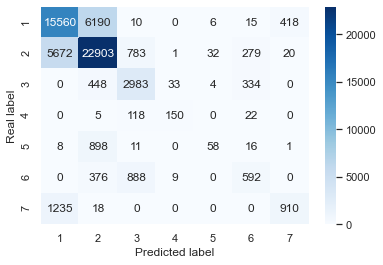

In [101]:
# Confusion Matrix
class_labels=[1,2,3,4,5,6,7]

#confusion_matrix_(X_train_multi_poly, y_multi, class_labels_multi_poly, model_imb_multi, class_labels)
confusion_matrix_wo_crossval(X_train_multi_poly, y_multi, class_labels_multi_poly, model_imb_multi, class_labels)

Interestingly the accuracy score of using the PolynomialFeatures did not improve. 

The confusion matrix also shows that there are more wrongly classified cases now in this case. 

Thus, I did not submitted this version to Kaggle, only the previous one with Elevation squared and interacted with the Soil Type dummies. 

In the Appendix" Jupyter Notebook you'll find some extra techniques which I tried to improve the performance of my multiclass prediction. At the end, the RandomForestClassifier performed the best, which I submitted to Kaggle, because on the training set it achieved a 1.0 accuracy and I was curious how well it performs on test set and on Kaggle. 

-----